In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
import pandas as pd
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-07-09 22:19:23,446 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-07-09 22:19:23,447 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Load Data

In [3]:
import pandas as pd

matching_tenzer = pd.read_csv(
    "/cmnfs/data/proteomics/timstof_hela_fractionation/Tenzer.matching_MaxQuant.txt/txt/evidence.txt",
    delimiter="\t",
)
nomatching_tenzer = pd.read_csv(
    "/cmnfs/data/proteomics/timstof_hela_fractionation/Tenzer.nomatching_MaxQuant.txt/txt/evidence.txt",
    delimiter="\t",
)

/tmp/ipykernel_1850590/1179936481.py:3: DtypeWarning: Columns (60,69) have mixed types. Specify dtype option on import or set low_memory=False.
  matching_tenzer = pd.read_csv(
/tmp/ipykernel_1850590/1179936481.py:7: DtypeWarning: Columns (60,69) have mixed types. Specify dtype option on import or set low_memory=False.
  nomatching_tenzer = pd.read_csv(


In [4]:
matching_tenzer["Experiment"].value_counts()
matching_tenzer["Raw file"].value_counts()

HYE124A    156972
HYE124B    148636
Name: Experiment, dtype: int64

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_891    53423
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_890    51913
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_892    51636
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_893    50027
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_894    49807
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_895    48802
Name: Raw file, dtype: int64

In [5]:
nomatching_tenzer["Experiment"].value_counts()
nomatching_tenzer["Raw file"].value_counts()

HYE124A    115699
HYE124B    103668
Name: Experiment, dtype: int64

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_891    39811
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_890    39104
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_892    36784
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_893    34922
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_894    34754
20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_895    33992
Name: Raw file, dtype: int64

# Curate Raw file specific dictionary

## Generate a reference dictionary from nomatching

In [15]:
import re
import numpy as np
from utils.tools import cleanup_maxquant

nomatching_tenzer = cleanup_maxquant(
    nomatching_tenzer, remove_decoys=True, how_duplicates="keep_all"
)
unique_pcm_group = (
    nomatching_tenzer.groupby(by=["Modified sequence", "Charge"])
    .agg(
        {
            "Raw file": "nunique",
            "Retention time": ["mean", np.var, "min", "max"],
            "1/K0": ["mean", np.var, "min", "max"],
        }
    )
    .reset_index()
)

2024-07-02 16:04:43,244 - utils.tools - INFO - Removing 273 decoys from experiment file, 219094 entries left.


In [16]:
unique_pcm_group.columns
unique_pcm_group.columns = unique_pcm_group.columns.map(
    lambda x: x[0] if x[1] == "" else x[0] + "_" + x[1]
)
unique_pcm_group.columns

MultiIndex([('Modified sequence',        ''),
            (           'Charge',        ''),
            (         'Raw file', 'nunique'),
            (   'Retention time',    'mean'),
            (   'Retention time',     'var'),
            (   'Retention time',     'min'),
            (   'Retention time',     'max'),
            (             '1/K0',    'mean'),
            (             '1/K0',     'var'),
            (             '1/K0',     'min'),
            (             '1/K0',     'max')],
           )

Index(['Modified sequence', 'Charge', 'Raw file_nunique',
       'Retention time_mean', 'Retention time_var', 'Retention time_min',
       'Retention time_max', '1/K0_mean', '1/K0_var', '1/K0_min', '1/K0_max'],
      dtype='object')

<Axes: >

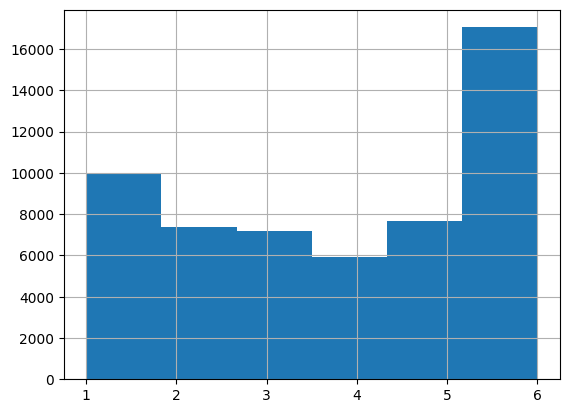

In [17]:
unique_pcm_group["Raw file_nunique"].hist(bins=6)

In [18]:
unique_pcm_group["Retention time_var"].describe()

count    45224.000000
mean         0.439931
std         12.258674
min          0.000000
25%          0.006309
50%          0.011033
75%          0.019591
max       1333.396440
Name: Retention time_var, dtype: float64

In [19]:
unique_pcm_group["1/K0_var"].describe()

count    45281.000000
mean         0.000077
std          0.000443
min          0.000000
25%          0.000002
50%          0.000003
75%          0.000005
max          0.015218
Name: 1/K0_var, dtype: float64

## Merge to create raw file specific result

In [25]:
# Filter entries from nomatching_tenzer for each Raw file
raw_files = nomatching_tenzer["Raw file"].unique()
maxquant_result_path = "/cmnfs/data/proteomics/timstof_hela_fractionation/"

In [26]:
for raw_file in raw_files:
    df_raw_file = nomatching_tenzer[nomatching_tenzer["Raw file"] == raw_file]
    df_raw_file = cleanup_maxquant(df_raw_file)
    df_raw_file.to_csv(
        os.path.join(maxquant_result_path, f"no_mbr_{raw_file}.txt"),
        index=False,
        sep="\t",
    )

2024-07-02 16:13:15,498 - utils.tools - INFO - Removing 0 decoys from experiment file, 39064 entries left.


2024-07-02 16:13:15,579 - utils.tools - INFO - Removing 1593 duplicate entries from experiment file, 37471 entries left.
2024-07-02 16:13:17,127 - utils.tools - INFO - Removing 0 decoys from experiment file, 39763 entries left.
2024-07-02 16:13:17,211 - utils.tools - INFO - Removing 1572 duplicate entries from experiment file, 38191 entries left.
2024-07-02 16:13:18,763 - utils.tools - INFO - Removing 0 decoys from experiment file, 36734 entries left.
2024-07-02 16:13:18,880 - utils.tools - INFO - Removing 1392 duplicate entries from experiment file, 35342 entries left.
2024-07-02 16:13:20,328 - utils.tools - INFO - Removing 0 decoys from experiment file, 34871 entries left.
2024-07-02 16:13:20,407 - utils.tools - INFO - Removing 1305 duplicate entries from experiment file, 33566 entries left.
2024-07-02 16:13:21,788 - utils.tools - INFO - Removing 0 decoys from experiment file, 34709 entries left.
2024-07-02 16:13:21,866 - utils.tools - INFO - Removing 1286 duplicate entries from expe

In [23]:
merged_df = pd.merge(
    df_raw_file,
    unique_pcm_group[
        [
            "Modified sequence",
            "Charge",
            "Retention time_mean",
            "Retention time_var",
            "Retention time_min",
            "Retention time_max",
            "1/K0_mean",
            "1/K0_var",
            "1/K0_min",
            "1/K0_max",
        ]
    ],
    how="outer",
    right_on=("Modified sequence", "Charge"),
    left_on=("Modified sequence", "Charge"),
    indicator=True,
    # suffixes=("", "_y"),
)

In [5]:
import pandas as pd

lib = pd.read_csv(
    "/cmnfs/data/dia_PASEF_HeLa_dilution_series/DIA_NN_analysis/pro2-lib.tsv",
    sep="\t",
)

In [8]:
lib.columns

Index(['FileName', 'PrecursorMz', 'ProductMz', 'Tr_recalibrated',
       'IonMobility', 'transition_name', 'LibraryIntensity',
       'transition_group_id', 'decoy', 'PeptideSequence', 'Proteotypic',
       'QValue', 'PGQValue', 'Ms1ProfileCorr', 'ProteinGroup', 'ProteinName',
       'Genes', 'FullUniModPeptideName', 'ModifiedPeptide', 'PrecursorCharge',
       'PeptideGroupLabel', 'UniprotID', 'NTerm', 'CTerm', 'FragmentType',
       'FragmentCharge', 'FragmentSeriesNumber', 'FragmentLossType',
       'ExcludeFromAssay'],
      dtype='object')

In [11]:
lib[["PeptideGroupLabel", "PrecursorCharge"]].nunique()

PeptideGroupLabel    156378
PrecursorCharge           2
dtype: int64